<a href="https://colab.research.google.com/github/yinpu/deep_learning_study/blob/master/MFFRM3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 数据预处理

In [ ]:
#数据预处理函数
import numpy as np
import os
import  tensorflow as tf

RATING_FILE_NAME={
    'movie': 'ratings.dat',
    'book':'BX-Book-Ratings.csv',
    'music':'user_artists.dat'
}
SEP={
    'movie':'::',
    'book':';',
    'music':'\t'
}
THRESHOLD={
    'movie':4,
    'book':0,
    'music':0
}
DATASETS={'movie','book','music'}

def read_item_index2entity_id_file():
    file = './data/'+DATASET+'/item_index2entity_id.txt'
    i=0
    for line in open(file,encoding='utf-8').readlines():
        item_index=line.strip().split('\t')[0]
        satori_id=line.strip().split('\t')[1]
        item_index_old2new[item_index]=i
        entity_id2index[satori_id]=i
        i+=1
        
def convert_rating():
    file = './data/'+DATASET+'/'+RATING_FILE_NAME[DATASET]
    item_set=set(item_index_old2new.values())
    user_pos_rating={}
    user_neg_rating={}
    for line in open(file,encoding='utf-8').readlines():
        array =line.strip().split(SEP[DATASET])
        if DATASET=='book':
            array=list(map(lambda x:x[1:-1],array))
        item_index_old=array[1]
        if item_index_old not in item_index_old2new:
            continue
        item_index=item_index_old2new[item_index_old]
        user_index_old=int(array[0])
        rating=float(array[2])
        if rating >=THRESHOLD[DATASET]:
            if user_index_old not in user_pos_rating:
                user_pos_rating[user_index_old]=set()
            user_pos_rating[user_index_old].add(item_index)
        else:
            if user_index_old not in user_neg_rating:
                user_neg_rating[user_index_old]=set()
            user_neg_rating[user_index_old].add(item_index)
    print('coverting rating file . . .')
    writer=open('data/'+DATASET+'/rating_final.txt','w',encoding='utf-8')
    user_cnt=0
    user_index_old2new={}
    for user_index_old,pos_item_set in user_pos_rating.items():
        if user_index_old not in user_index_old2new:
            user_index_old2new[user_index_old]=user_cnt
            user_cnt+=1
        user_index=user_index_old2new[user_index_old]
        for item in pos_item_set:
            writer.write("%d\t%d\t1\n"%(user_index,item))
        unwatch_set=item_set-pos_item_set
        if user_index_old in user_neg_rating:
            unwatch_set-=user_neg_rating[user_index_old]
        for item in np.random.choice(list(unwatch_set),size=len(pos_item_set),replace=False):
            writer.write("%d\t%d\t0\n"%(user_index,item))
    writer.close()
    print("num of users:",user_cnt)
    print("num of item:",len(item_set))

def convert_kg():
    print('converting kg.txt file')
    entity_cnt=len(entity_id2index)
    relation_cnt=0
    writer=open('data/'+DATASET+'/kg_final.txt','w',encoding='utf-8')
    file=open('data/'+DATASET+'/kg.txt','r',encoding='utf-8')
    for line in file:
        array=line.strip().split('\t')
        head_old=array[0]
        relation_old=array[1]
        tail_old=array[2]
        if head_old not in entity_id2index:
            continue
        head=entity_id2index[head_old]
        if tail_old not in entity_id2index:
            entity_id2index[tail_old]=entity_cnt
            entity_cnt+=1
        tail=entity_id2index[tail_old]
        if relation_old not in relation_id2index:
            relation_id2index[relation_old]=relation_cnt
            relation_cnt+=1
        relation=relation_id2index[relation_old]
        writer.write("%d\t%d\t%d\n"%(head,relation,tail))
    writer.close()
    print('num of entities:',entity_cnt)
    print('num of relations:',relation_cnt)


In [ ]:
#数据集处理
for DATASET in DATASETS:
    print(DATASET+"  :   ")
    np.random.seed(555)
    entity_id2index={}
    relation_id2index={}
    item_index_old2new={}
    read_item_index2entity_id_file()
    convert_rating()
    convert_kg()

movie  :   


FileNotFoundError: ignored

# 数据加载

In [ ]:
def load_data(DATASET):
    n_user,n_item,train_data,eval_data,test_data=load_rating(DATASET)
    n_entity,n_relation,kg=load_kg(DATASET)
    print('data loaded')
    return n_user,n_item,n_entity,n_relation,train_data,eval_data,test_data,kg

def load_rating(DATASET):
    print('reading rating file ....')
    rating_file='data/'+DATASET+'/rating_final'
    if os.path.exists(rating_file+'.npy'):
        rating_np=np.load(rating_file+'.npy')
    else:
        rating_np=np.loadtxt(rating_file+'.txt',dtype=np.int32)
        np.save(rating_file+'.npy',rating_np)
    n_user=len(set(rating_np[:,0]))
    n_item=len(set(rating_np[:,1]))
    train_data,eval_data,test_data=dataset_split(rating_np)
    return n_user,n_item,train_data,eval_data,test_data

def dataset_split(rating_np):
    print('splitting dataset ...')
    eval_ratio=0.2
    test_ration=0.2
    n_rating=rating_np.shape[0]
    eval_indices=np.random.choice(list(range(n_rating)),size=int(n_rating*eval_ratio),replace=False)
    left=set(range(n_rating))-set(eval_indices)
    test_indices=np.random.choice(list(left),size=int(n_rating*test_ration),replace=False)
    train_indices=list(left-set(test_indices))
    train_data,eval_data,test_data=rating_np[train_indices],rating_np[eval_indices],rating_np[test_indices]
    return train_data,eval_data,test_data
def load_kg(DATASET):
    print('reading KG file')
    kg_file='data/'+DATASET+'/kg_final'
    if os.path.exists(kg_file + '.npy'):
        kg = np.load(kg_file + '.npy')
    else:
        kg = np.loadtxt(kg_file + '.txt', dtype=np.int32)
        np.save(kg_file + '.npy', kg)
    n_entity=len(set(kg[:,0])|set(kg[:,2]))
    n_relation=len(set(kg[:,1]))
    return n_entity,n_relation,kg

# 交叉压缩层

In [ ]:
class CrossLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(CrossLayer,self).__init__(**kwargs)
    def call(self, inputs,):
        v,e=inputs
        v=tf.expand_dims(v,axis=2)
        e=tf.expand_dims(e,axis=1)
        c_matrix=v@e
        c_matrix_t=tf.transpose(c_matrix,perm=[0,2,1])
        return c_matrix,c_matrix_t,inputs
    def get_config(self):
        config = {}
        base_config = super(CrossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class CompressLayer(tf.keras.layers.Layer):
    def __init__(self,weight_regularizer,**kwargs):
        super(CompressLayer,self).__init__(**kwargs)
        self.weight_regularizer=tf.keras.regularizers.get(weight_regularizer)
    def build(self, input_shape):
        self.dim=input_shape[0][-1]
        self.kernel=self.add_weight(name='kernel',shape=(self.dim,1),regularizer=self.weight_regularizer)
        self.kernel_t=self.add_weight(name='kernel_t',shape=(self.dim,1),regularizer=self.weight_regularizer)
        self.bias=self.add_weight(name='bias',shape=(self.dim,),initializer=tf.initializers.zeros)
    def call(self, inputs):
        c_matrix,c_matrix_t,(v,e)=inputs
        c_matrix=tf.reshape(c_matrix,shape=(-1,self.dim))
        c_matrix_t=tf.reshape(c_matrix_t,shape=(-1,self.dim))
        return tf.reshape(c_matrix@self.kernel+c_matrix_t@self.kernel_t,shape=(-1,self.dim))+v+e+self.bias
    def get_config(self):
        config = {
            'weight_regularizer': tf.keras.regularizers.serialize(self.weight_regularizer)
        }
        base_config = super(CompressLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def cross_compress_unit(inputs,weight_regularizer):
    v,e=inputs
    dim=v.shape[-1]
    v=tf.keras.layers.Dense(dim,activation=None,kernel_regularizer=weight_regularizer)(v)
    e=tf.keras.layers.Dense(dim,activation=None,kernel_regularizer=weight_regularizer)(e)
    cross_feature_matrix=CrossLayer()((v,e))
    v_out=CompressLayer(weight_regularizer)(cross_feature_matrix)
    e_out=CompressLayer(weight_regularizer)(cross_feature_matrix)
    return v_out,e_out

# 模型定义

In [ ]:
def DFM_MKR_model(n_user,n_item,n_entity,n_relation,dim=8,L=1,H=1,l2=1e-6,use_inner_product=True):
    l2=tf.keras.regularizers.l2(l2)
    user_id=tf.keras.Input(shape=(),dtype=tf.int32,name='user_id')
    item_id=tf.keras.Input(shape=(),dtype=tf.int32,name='item_id')
    head_id=tf.keras.Input(shape=(),dtype=tf.int32,name='head_id')
    relation_id=tf.keras.Input(shape=(),dtype=tf.int32,name='relation_id')
    tail_id=tf.keras.Input(shape=(),dtype=tf.int32,name='tail_id')
    user_embedding=tf.keras.layers.Embedding(input_dim=n_user,output_dim=dim,
                                             embeddings_regularizer=l2)
    item_embedding=tf.keras.layers.Embedding(input_dim=n_item,output_dim=dim,
                                             embeddings_regularizer=l2)
    entity_embedding=tf.keras.layers.Embedding(input_dim=n_entity,output_dim=dim,
                                               embeddings_regularizer=l2)
    relation_embedding=tf.keras.layers.Embedding(input_dim=n_relation,output_dim=dim,
                                               embeddings_regularizer=l2)
    u=user_embedding(user_id)
    i=item_embedding(item_id)
    h=entity_embedding(head_id)
    t=entity_embedding(tail_id)
    r=relation_embedding(relation_id)
    for _ in range(L):
        u=tf.keras.layers.Dense(dim,activation=tf.keras.activations.relu,kernel_regularizer=l2)(u)
        i,h=cross_compress_unit(inputs=(i,h),weight_regularizer=l2)
        t=tf.keras.layers.Dense(dim,activation=tf.keras.activations.relu,kernel_regularizer=l2)(t)

    rs=tf.keras.activations.relu(u*i)
    for _ in range(H-1):
        rs=tf.keras.layers.Dense(dim,activation=tf.keras.activations.relu,kernel_regularizer=l2)(rs)
    rs=tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid,kernel_regularizer=l2)(rs)

    kg = tf.concat([h, r], axis=1)
    for _ in range(H - 1):
        kg = tf.keras.layers.Dense(dim * 2, activation=tf.keras.activations.relu, kernel_regularizer=l2)(kg)
    kg = tf.keras.layers.Dense(dim, activation=tf.keras.activations.sigmoid, kernel_regularizer=l2)(kg)
    kg=-tf.keras.activations.sigmoid(tf.reduce_sum(kg*t,axis=1))
    return tf.keras.Model(inputs=[user_id,item_id,head_id],outputs=rs),tf.keras.Model(inputs=[item_id,head_id,relation_id,tail_id],outputs=kg)


# 训练函数

In [ ]:
import time
def preprocess_rs_data(data):
    u = tf.constant(data[:, 0], dtype=tf.int32)
    i = tf.constant(data[:, 1], dtype=tf.int32)
    h = tf.constant(data[:, 1], dtype=tf.int32)
    r = tf.constant(data[:, 2], dtype=tf.float32)
    return {'user_id': u, 'item_id': i, 'head_id': h}, r


def preprocess_kg_data(data):
    i = tf.constant(data[:, 0], dtype=tf.int32)
    h = tf.constant(data[:, 0], dtype=tf.int32)
    r = tf.constant(data[:, 1], dtype=tf.int32)
    t = tf.constant(data[:, 2], dtype=tf.int32)
    l = tf.zeros(len(data), dtype=tf.float32)
    return {'item_id': i, 'head_id': h, 'relation_id': r, 'tail_id': t}, l


def train(DATASET, DEFAULT):
    n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
    print(train_data.shape)
    rs_model, kg_model = DFM_MKR_model(n_user, n_item, n_entity, n_relation, dim=DEFAULT[DATASET]['dim'], H=DEFAULT[DATASET]['H'],L=DEFAULT[DATASET]['L'])
    epochs = DEFAULT[DATASET]['epochs']
    kge_interval = DEFAULT[DATASET]['kge_interval']
    batch = DEFAULT[DATASET]['batch_size']
    rs_train_ds = tf.data.Dataset.from_tensor_slices(preprocess_rs_data(train_data))
    rs_train_ds = rs_train_ds.shuffle(len(train_data)).batch(batch)
    rs_eval_ds = tf.data.Dataset.from_tensor_slices(preprocess_rs_data(eval_data))
    rs_eval_ds = rs_eval_ds.batch(batch)
    kg_train_ds = tf.data.Dataset.from_tensor_slices(preprocess_kg_data(kg))
    kg_train_ds = kg_train_ds.shuffle(len(kg)).batch(batch)
    rs_model.compile(optimizer=tf.optimizers.Adam( DEFAULT[DATASET]['lr_rs']), loss=tf.keras.losses.binary_crossentropy,
                     metrics=['AUC', tf.keras.metrics.binary_accuracy])
    kg_model.compile(optimizer=tf.optimizers.Adam(DEFAULT[DATASET]['lr_kg']), loss=lambda y_true, y_pre: y_pre)
    t0=time.clock()
    for epoch in range(epochs):
        history=rs_model.fit(rs_train_ds, epochs=epoch + 1, validation_data=rs_eval_ds, verbose=0, initial_epoch=epoch)
        if epoch % kge_interval == 0:
            kg_model.fit(kg_train_ds, epochs=epoch + 1, initial_epoch=epoch, verbose=0)
       # rs_model.save('./log/' + DATASET + '/model/model_' + str(epoch) + '.h5')
    return time.clock() - t0

# topk测试

In [ ]:
def get_user_recoed(data, is_train):
    user_history_dict = {}
    for interaction in data:
        user = interaction[0]
        item = interaction[1]
        label = interaction[2]
        if is_train or label == 1:
            if user not in user_history_dict:
                user_history_dict[user] = set()
            user_history_dict[user].add(item)
    return user_history_dict


def topk_eval(model, user_list, train_record, test_record, item_set, k_list):
    precision_list = {k: [] for k in k_list}
    recall_list = {k: [] for k in k_list}
    for user in user_list:
        test_item_list = list(item_set - train_record[user])
        item_score_map = {}
        score = model({'user_id': tf.constant([user] * len(test_item_list)), 
                       'item_id': tf.constant(test_item_list), 
                       'head_id': tf.constant(test_item_list)})
        for item, score in zip(test_item_list, score):
            score=float(score)
            item_score_map[item] = score
        item_score_map_sorted = sorted(item_score_map.items(), key=lambda x: x[1], reverse=True)
        item_sorted = [i[0] for i in item_score_map_sorted]
        for k in k_list:
            hit_num = len(set(item_sorted[:k]) & test_record[user])
            precision_list[k].append(hit_num / k)
            recall_list[k].append(hit_num / len(test_record[user]))
    precision={}
    recall={}
    f1={}
    for k in k_list: 
        precision[k] = np.mean(precision_list[k]) 
        recall[k] = np.mean(recall_list[k]) 
        f1[k] = 2 / (1 / precision[k] + 1 / recall[k]) 
    return precision, recall, f1

# movie-len数据集

In [ ]:
DEFAULT={
        'movie': {'epochs': 60, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 10, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 32, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 10, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 256, 'lr_rs': 1e-3, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='movie'
tf.random.set_seed(555);
history=train(DATASET,DEFAULT)

reading rating file ....


OSError: ignored

In [ ]:
#测试ctr
DATASET='movie'
tf.random.set_seed(555);
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
network = tf.keras.models.load_model('./log/movie/model/model_46.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
network.evaluate([test_data[:,0],test_data[:,1],test_data[:,1]],test_data[:,2])

reading rating file ....
splitting dataset ...
reading KG file
data loaded


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


150754/150754 [==============================] - 6s 40us/sample - loss: 0.3243 - AUC: 0.9441 - binary_accuracy: 0.8727


[0.3242751293346249, 0.9440564, 0.87273306]

/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


reading rating file ....
splitting dataset ...
reading KG file
data loaded


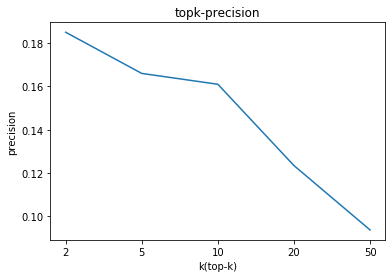

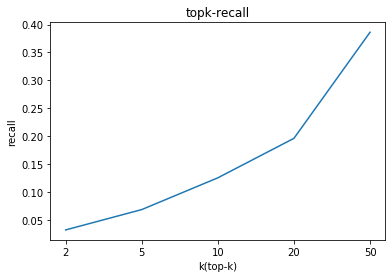

In [ ]:
from matplotlib import pyplot as plt
DATASET='movie'
network = tf.keras.models.load_model('./log/movie/model/model_46.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
user_num = 100
k_list = [2, 5, 10, 20, 50]
train_record = get_user_recoed(train_data, True)
test_record = get_user_recoed(test_data, False)
user_list = list(set(train_record.keys()) & set(test_record.keys()))
if len(user_list) > user_num:
    user_list = np.random.choice(user_list, size=user_num, replace=False)
item_set = set(list(range(n_item)))
precision, recall, f1=topk_eval(network,user_list,train_record,test_record,item_set,k_list)
data=[precision,recall,f1]
x=range(len(k_list))
y=[precision[k] for k in k_list]
plt.title('topk-precision')
plt.xlabel('k(top-k)')
plt.ylabel('precision')
plt.xticks(x,[2,5,10,20,50])
plt.plot(x,y)
plt.show()
x=range(len(k_list))
y=[recall[k] for k in k_list]
plt.title('topk-recall')
plt.xlabel('k(top-k)')
plt.ylabel('recall')
plt.xticks(x,[2,5,10,20,50])
plt.plot(x,y)
plt.show()

In [ ]:
data

[{2: 0.185,
  5: 0.16599999999999995,
  10: 0.161,
  20: 0.1235,
  50: 0.09380000000000001},
 {2: 0.03199736316054037,
  5: 0.06845414519837599,
  10: 0.125357162479954,
  20: 0.1961233914628588,
  50: 0.3862396506552564},
 {2: 0.05455837894509858,
  5: 0.09693484492087476,
  10: 0.14096035164257809,
  20: 0.1515611153164154,
  50: 0.15094286141575977}]

# last.fm数据集

In [ ]:
DEFAULT={
        'movie': {'epochs': 60, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 10, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 32, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 30, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 256, 'lr_rs': 1e-4, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='music'
history=train(DATASET,DEFAULT)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
Train for 100 steps, validate for 34 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - AUC: 0.5000 - binary_accuracy: 0.5153 - val_loss: 0.6932 - val_AUC: 0.5000 - val_binary_accuracy: 0.5246
Train for 61 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


61/61 [==============================] - 1s 20ms/step - loss: -0.5080
Train for 100 steps, validate for 34 steps
Epoch 2/2
100/100 [==============================] - 0s 5ms/step - loss: 0.6932 - AUC: 0.5009 - binary_accuracy: 0.5026 - val_loss: 0.6931 - val_AUC: 0.5033 - val_binary_accuracy: 0.5063
Train for 100 steps, validate for 34 steps
Epoch 3/3
100/100 [==============================] - 0s 4ms/step - loss: 0.6926 - AUC: 0.5387 - binary_accuracy: 0.5707 - val_loss: 0.6919 - val_AUC: 0.5975 - val_binary_accuracy: 0.6366
Train for 61 steps
Epoch 3/3
61/61 [==============================] - 0s 4ms/step - loss: -0.5202
Train for 100 steps, validate for 34 steps
Epoch 4/4
100/100 [==============================] - 0s 4ms/step - loss: 0.6890 - AUC: 0.7078 - binary_accuracy: 0.6475 - val_loss: 0.6856 - val_AUC: 0.7339 - val_binary_accuracy: 0.6931
Train for 100 steps, validate for 34 steps
Epoch 5/5
100/100 [==============================] - 1s 5ms/step - loss: 0.6759 - AUC: 0.7957 - bin

In [ ]:
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
network = tf.keras.models.load_model('./log/music/model/model_8.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
network.evaluate([test_data[:,0],test_data[:,1],test_data[:,1]],test_data[:,2])

reading rating file ....
splitting dataset ...
reading KG file
data loaded


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


8469/8469 [==============================] - 1s 77us/sample - loss: 0.4927 - AUC: 0.8445 - binary_accuracy: 0.7637


[0.4926955700694832, 0.8445339, 0.76372653]

In [ ]:
network.evaluate([eval_data[:,0],eval_data[:,1],eval_data[:,1]],eval_data[:,2])

8469/8469 [==============================] - 0s 49us/sample - loss: 0.4729 - AUC: 0.8533 - binary_accuracy: 0.7786


[0.472894996689686, 0.85331774, 0.7786043]

/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


reading rating file ....
splitting dataset ...
reading KG file
data loaded


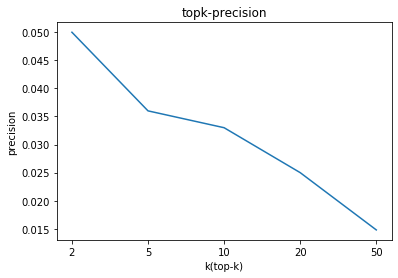

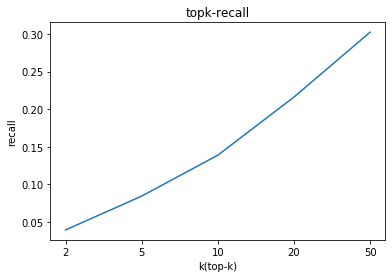

[{2: 0.05,
  5: 0.036000000000000004,
  10: 0.033,
  20: 0.024999999999999994,
  50: 0.0148},
 {2: 0.0395,
  5: 0.08449999999999999,
  10: 0.13883333333333334,
  20: 0.21600000000000003,
  50: 0.30216666666666664},
 {2: 0.044134078212290505,
  5: 0.0504896265560166,
  10: 0.05332492725509214,
  20: 0.04481327800829875,
  50: 0.028217898832684822}]

In [ ]:
from matplotlib import pyplot as plt
DATASET='music'
network = tf.keras.models.load_model('./log/music/model/model_10.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
user_num = 100
k_list = [2, 5, 10, 20, 50]
train_record = get_user_recoed(train_data, True)
test_record = get_user_recoed(test_data, False)
user_list = list(set(train_record.keys()) & set(test_record.keys()))
if len(user_list) > user_num:
    user_list = np.random.choice(user_list, size=user_num, replace=False)
item_set = set(list(range(n_item)))
precision, recall, f1=topk_eval(network,user_list,train_record,test_record,item_set,k_list)
data=[precision,recall,f1]
x=range(len(k_list))
y=[precision[k] for k in k_list]
plt.title('topk-precision')
plt.xlabel('k(top-k)')
plt.ylabel('precision')
plt.xticks(x,[2,5,10,20,50])
plt.plot(x,y)
plt.show()
x=range(len(k_list))
y=[recall[k] for k in k_list]
plt.title('topk-recall')
plt.xlabel('k(top-k)')
plt.ylabel('recall')
plt.xticks(x,[2,5,10,20,50])
plt.plot(x,y)
plt.show()
data

# book数据集

In [ ]:
DEFAULT={
        'movie': {'epochs': 30, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 10, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 32, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 10, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 256, 'lr_rs': 1e-3, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='book'
history=train(DATASET,DEFAULT)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
Train for 2621 steps, validate for 874 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


2621/2621 [==============================] - 13s 5ms/step - loss: 0.6460 - AUC: 0.6604 - binary_accuracy: 0.5969 - val_loss: 0.5816 - val_AUC: 0.7365 - val_binary_accuracy: 0.6973
Train for 619 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


619/619 [==============================] - 3s 4ms/step - loss: -0.5075
Train for 2621 steps, validate for 874 steps
Epoch 2/2
2621/2621 [==============================] - 12s 5ms/step - loss: 0.5363 - AUC: 0.7992 - binary_accuracy: 0.7333 - val_loss: 0.5818 - val_AUC: 0.7454 - val_binary_accuracy: 0.7000
Train for 2621 steps, validate for 874 steps
Epoch 3/3
2621/2621 [==============================] - 12s 5ms/step - loss: 0.4965 - AUC: 0.8373 - binary_accuracy: 0.7550 - val_loss: 0.5990 - val_AUC: 0.7454 - val_binary_accuracy: 0.6986
Train for 619 steps
Epoch 3/3
619/619 [==============================] - 2s 3ms/step - loss: -0.5232
Train for 2621 steps, validate for 874 steps
Epoch 4/4
2621/2621 [==============================] - 12s 4ms/step - loss: 0.4720 - AUC: 0.8534 - binary_accuracy: 0.7607 - val_loss: 0.6244 - val_AUC: 0.7432 - val_binary_accuracy: 0.6939
Train for 2621 steps, validate for 874 steps
Epoch 5/5
2621/2621 [==============================] - 12s 5ms/step - loss: 0.

In [ ]:
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
network = tf.keras.models.load_model('./log/book/model/model_3.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
network.evaluate([test_data[:,0],test_data[:,1],test_data[:,1]],test_data[:,2])

reading rating file ....
splitting dataset ...
reading KG file
data loaded


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


27949/27949 [==============================] - 2s 62us/sample - loss: 0.5083 - AUC: 0.8282 - binary_accuracy: 0.7455


[0.5083015842034081, 0.8282367, 0.74550074]

In [ ]:
network.evaluate([eval_data[:,0],eval_data[:,1],eval_data[:,1]],eval_data[:,2])

27949/27949 [==============================] - 2s 56us/sample - loss: 0.5106 - AUC: 0.8258 - binary_accuracy: 0.7440


[0.5106167498908148, 0.8258266, 0.74403375]

/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


reading rating file ....
splitting dataset ...
reading KG file
data loaded


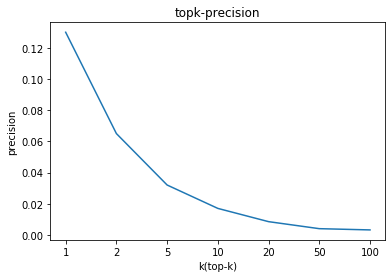

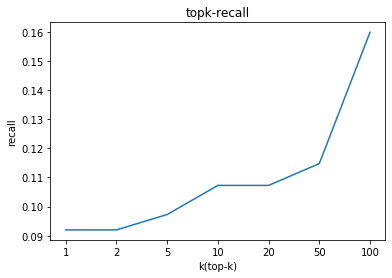

[{1: 0.13,
  2: 0.065,
  5: 0.032,
  10: 0.017,
  20: 0.0085,
  50: 0.004,
  100: 0.0032000000000000006},
 {1: 0.092,
  2: 0.092,
  5: 0.09727777777777778,
  10: 0.10727777777777778,
  20: 0.10727777777777778,
  50: 0.11477777777777778,
  100: 0.15985714285714286},
 {1: 0.10774774774774774,
  2: 0.07617834394904459,
  5: 0.048158143532445206,
  10: 0.029349128296826107,
  20: 0.015751919385796547,
  50: 0.007730589335827876,
  100: 0.006274399859821273}]

In [ ]:
from matplotlib import pyplot as plt
DATASET='book'
network = tf.keras.models.load_model('./log/book/model/model_3.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
user_num = 100
k_list = [1, 2, 5, 10, 20, 50, 100]
train_record = get_user_recoed(train_data, True)
test_record = get_user_recoed(test_data, False)
user_list = list(set(train_record.keys()) & set(test_record.keys()))
if len(user_list) > user_num:
    user_list = np.random.choice(user_list, size=user_num, replace=False)
item_set = set(list(range(n_item)))
precision, recall, f1=topk_eval(network,user_list,train_record,test_record,item_set,k_list)
data=[precision,recall,f1]
x=range(len(k_list))
y=[precision[k] for k in k_list]
plt.title('topk-precision')
plt.xlabel('k(top-k)')
plt.ylabel('precision')
plt.xticks(x,[1,2,5,10,20,50,100])
plt.plot(x,y)
plt.show()
x=range(len(k_list))
y=[recall[k] for k in k_list]
plt.title('topk-recall')
plt.xlabel('k(top-k)')
plt.ylabel('recall')
plt.xticks(x,[1,2,5,10,20,50,100])
plt.plot(x,y)
plt.show()
data

# 实验对比(GMF)

In [ ]:
def FM_model(n_user, n_item, dim=8, l2=1e-6):
    l2 = tf.keras.regularizers.l2(l2)

    user_id = tf.keras.Input(shape=(), name='user_id', dtype=tf.int32)
    u = tf.keras.layers.Embedding(n_user, dim, embeddings_regularizer=l2)(user_id)
    item_id = tf.keras.Input(shape=(), name='item_id', dtype=tf.int32)
    i = tf.keras.layers.Embedding(n_item, dim, embeddings_regularizer=l2)(item_id)

    x = u * i
    x = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2)(x)
    return tf.keras.Model(inputs=[user_id, item_id], outputs=x)

In [ ]:
#GMF模型
def preprocess_data(data):
    u = tf.constant(data[:, 0], dtype=tf.int32)
    i = tf.constant(data[:, 1], dtype=tf.int32)
    h = tf.constant(data[:, 1], dtype=tf.int32)
    r = tf.constant(data[:, 2], dtype=tf.float32)
    return {'user_id': u, 'item_id': i}, r

def fm_train(DATASET, DEFAULT):
    n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
    fm_model = FM_model(n_user, n_item,dim=DEFAULT[DATASET]['dim'])
    epochs = DEFAULT[DATASET]['epochs']
    batch = DEFAULT[DATASET]['batch_size']
    train_ds = tf.data.Dataset.from_tensor_slices(preprocess_data(train_data))
    train_ds = train_ds.shuffle(len(train_data)).batch(batch)
    eval_ds = tf.data.Dataset.from_tensor_slices(preprocess_data(eval_data))
    eval_ds =eval_ds.batch(batch)
    fm_model.compile(optimizer=tf.optimizers.Adam( DEFAULT[DATASET]['lr_rs']), loss=tf.keras.losses.binary_crossentropy,
                     metrics=['AUC', tf.keras.metrics.binary_accuracy])
    for epoch in range(epochs):
        history=fm_model.fit(train_ds, epochs=epoch + 1, validation_data=eval_ds, verbose=1, initial_epoch=epoch)
    return fm_model

In [ ]:
DEFAULT={
        'movie': {'epochs': 8, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 10, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 32, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 30, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 256, 'lr_rs': 1e-4, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='movie'
fm_model=fm_train(DATASET,DEFAULT)

NameError: ignored

In [ ]:
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
fm_model.evaluate([test_data[:,0],test_data[:,1]],test_data[:,2])

reading rating file ....
splitting dataset ...
reading KG file
data loaded
150754/150754 [==============================] - 5s 36us/sample - loss: 0.3230 - AUC: 0.9443 - binary_accuracy: 0.8741


[0.3229793632330341, 0.94430685, 0.87410617]

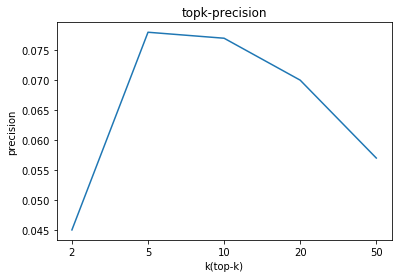

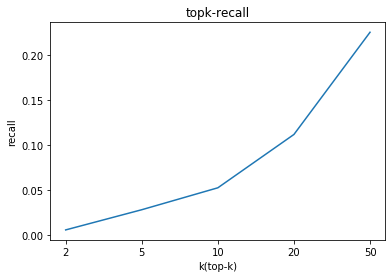

[{2: 0.045, 5: 0.078, 10: 0.077, 20: 0.07, 50: 0.056999999999999995},
 {2: 0.006161934429230217,
  5: 0.028577182698116963,
  10: 0.0529290077384699,
  20: 0.11214410204887085,
  50: 0.2256150675862347},
 {2: 0.010839584249845645,
  5: 0.04182922073980674,
  10: 0.06273477596420499,
  20: 0.08619644616672477,
  50: 0.091007595329229}]

In [ ]:
from matplotlib import pyplot as plt
DATASET='movie'
user_num = 100
k_list = [2, 5, 10, 20, 50]
train_record = get_user_recoed(train_data, True)
test_record = get_user_recoed(test_data, False)
user_list = list(set(train_record.keys()) & set(test_record.keys()))
if len(user_list) > user_num:
    user_list = np.random.choice(user_list, size=user_num, replace=False)
item_set = set(list(range(n_item)))
precision, recall, f1=topk_eval(fm_model,user_list,train_record,test_record,item_set,k_list)
data=[precision,recall,f1]
x=range(len(k_list))
y=[precision[k] for k in k_list]
plt.title('topk-precision')
plt.xlabel('k(top-k)')
plt.ylabel('precision')
plt.xticks(x,[2,5,10,20,50])
plt.plot(x,y)
plt.show()
x=range(len(k_list))
y=[recall[k] for k in k_list]
plt.title('topk-recall')
plt.xlabel('k(top-k)')
plt.ylabel('recall')
plt.xticks(x,[2,5,10,20,50])
plt.plot(x,y)
plt.show()
data

In [ ]:
DEFAULT={
        'movie': {'epochs': 8, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 20, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 32, 'lr_rs': 2e-1, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 25, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 256, 'lr_rs': 1e-3, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='music'
fm_model=fm_train(DATASET,DEFAULT)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
Train for 100 steps, validate for 34 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


100/100 [==============================] - 2s 18ms/step - loss: 0.6900 - AUC: 0.6772 - binary_accuracy: 0.6356 - val_loss: 0.6869 - val_AUC: 0.7399 - val_binary_accuracy: 0.6819
Train for 100 steps, validate for 34 steps
Epoch 2/2
100/100 [==============================] - 0s 4ms/step - loss: 0.6806 - AUC: 0.8423 - binary_accuracy: 0.7759 - val_loss: 0.6809 - val_AUC: 0.7490 - val_binary_accuracy: 0.6860
Train for 100 steps, validate for 34 steps
Epoch 3/3
100/100 [==============================] - 0s 4ms/step - loss: 0.6714 - AUC: 0.8687 - binary_accuracy: 0.7969 - val_loss: 0.6751 - val_AUC: 0.7495 - val_binary_accuracy: 0.6897
Train for 100 steps, validate for 34 steps
Epoch 4/4
100/100 [==============================] - 0s 4ms/step - loss: 0.6619 - AUC: 0.8829 - binary_accuracy: 0.8084 - val_loss: 0.6694 - val_AUC: 0.7503 - val_binary_accuracy: 0.6917
Train for 100 steps, validate for 34 steps
Epoch 5/5
100/100 [==============================] - 0s 4ms/step - loss: 0.6518 - AUC: 0.

In [ ]:
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
fm_model.evaluate([test_data[:,0],test_data[:,1]],test_data[:,2])

reading rating file ....
splitting dataset ...
reading KG file
data loaded
8469/8469 [==============================] - 1s 70us/sample - loss: 0.4639 - AUC: 0.9104 - binary_accuracy: 0.8317


[0.4639349246633167, 0.91039854, 0.8317393]

In [ ]:
DEFAULT={
        'movie': {'epochs': 10, 'dim':4, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 10, 'dim': 16, 'L': 1, 'H': 1, 'batch_size': 32, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 10, 'dim': 8, 'L': 2, 'H': 1, 'batch_size': 256, 'lr_rs': 1e-3, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='music'
tf.random.set_seed(555);
history=train(DATASET,DEFAULT)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
Train for 100 steps, validate for 34 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


100/100 [==============================] - 2s 23ms/step - loss: 0.6746 - AUC: 0.6635 - binary_accuracy: 0.5830 - val_loss: 0.6225 - val_AUC: 0.7813 - val_binary_accuracy: 0.7321
Train for 61 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


61/61 [==============================] - 1s 22ms/step - loss: -0.5109
Train for 100 steps, validate for 34 steps
Epoch 2/2
100/100 [==============================] - 1s 5ms/step - loss: 0.5091 - AUC: 0.8316 - binary_accuracy: 0.7692 - val_loss: 0.5319 - val_AUC: 0.7986 - val_binary_accuracy: 0.7450
Train for 100 steps, validate for 34 steps
Epoch 3/3
100/100 [==============================] - 1s 5ms/step - loss: 0.4265 - AUC: 0.8840 - binary_accuracy: 0.7910 - val_loss: 0.5721 - val_AUC: 0.8028 - val_binary_accuracy: 0.7366
Train for 61 steps
Epoch 3/3
61/61 [==============================] - 0s 5ms/step - loss: -0.5321
Train for 100 steps, validate for 34 steps
Epoch 4/4
100/100 [==============================] - 0s 5ms/step - loss: 0.3979 - AUC: 0.8966 - binary_accuracy: 0.7968 - val_loss: 0.6052 - val_AUC: 0.7999 - val_binary_accuracy: 0.7295
Train for 100 steps, validate for 34 steps
Epoch 5/5
100/100 [==============================] - 1s 6ms/step - loss: 0.3763 - AUC: 0.9060 - bin

In [ ]:
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
network.evaluate([test_data[:,0],test_data[:,1],test_data[:,1]],test_data[:,2])

# 时间测试

In [ ]:
from google.colab import drive
import os
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/Shared drives/yinpu/MyProject/newMKR')

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
import time
DEFAULT={
        'movie': {'epochs': 50, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 50, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 50, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 4096, 'lr_rs': 1e-3, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='movie'
tf.random.set_seed(555);
l=0
for i in range(50):
  l+=train(DATASET,DEFAULT)
  print(l)
print(l)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


160.00932899999998
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
320.545619
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
478.98556299999996
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
638.392945
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
801.5305070000002
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
960.5866250000001
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
1118.6139880000003
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
1265.5326750000002
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
1410.1789320000005
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
1555.6329280000007
reading rating file ....
splitting dataset ..

In [ ]:
DATASET='book'
tf.random.set_seed(555)
l=0
for i in range(50):
  l+=train(DATASET,DEFAULT)
  print(l)
print(l)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


33.31891899999937
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
66.92588199999955
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
100.43594099999973
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
134.11375099999896
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
168.16303699999844
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
201.59026699999777
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
235.17297399999734
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
268.66298299999835
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
301.9603799999986
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
335.4822729999996
reading rating file ....
splitting datas

In [ ]:
DATASET='music'
tf.random.set_seed(555)
l=0
for i in range(50):
  l+=train(DATASET,DEFAULT)
  print(l)
print(l)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


14.133520000001226
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
28.515638000000763
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
42.65419800000018
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
56.71827300000041
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
71.22450199999912
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
85.26225999999951
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
99.43175299999893
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
113.62154799999735
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
128.18257599999743
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
142.22072099999787
reading rating file ....
splitting datase

In [ ]:
import  tensorflow as tf
class MKRCrossLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(MKRCrossLayer,self).__init__(**kwargs)
    def call(self, inputs,):
        v,e=inputs
        v=tf.expand_dims(v,axis=2)
        e=tf.expand_dims(e,axis=1)
        c_matrix=v@e
        c_matrix_t=tf.transpose(c_matrix,perm=[0,2,1])
        return c_matrix,c_matrix_t
    def get_config(self):
        config = {}
        base_config = super(MKRCrossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class MKRCompressLayer(tf.keras.layers.Layer):
    def __init__(self,weight_regularizer,**kwargs):
        super(MKRCompressLayer,self).__init__(**kwargs)
        self.weight_regularizer=tf.keras.regularizers.get(weight_regularizer)
    def build(self, input_shape):
        self.dim=input_shape[0][-1]
        self.kernel=self.add_weight(name='kernel',shape=(self.dim,1),regularizer=self.weight_regularizer)
        self.kernel_t=self.add_weight(name='kernel_t',shape=(self.dim,1),regularizer=self.weight_regularizer)
        self.bias=self.add_weight(name='bias',shape=(self.dim,),initializer=tf.initializers.zeros)
    def call(self, inputs):
        c_matrix,c_matrix_t=inputs
        c_matrix=tf.reshape(c_matrix,shape=(-1,self.dim))
        c_matrix_t=tf.reshape(c_matrix_t,shape=(-1,self.dim))
        return tf.reshape(c_matrix@self.kernel+c_matrix_t@self.kernel_t,shape=(-1,self.dim))+self.bias
    def get_config(self):
        config = {
            'weight_regularizer': tf.keras.regularizers.serialize(self.weight_regularizer)
        }
        base_config = super(MKRCompressLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def MKRcross_compress_unit(inputs,weight_regularizer):
    cross_feature_matrix=MKRCrossLayer()(inputs)
    v_out=MKRCompressLayer(weight_regularizer)(cross_feature_matrix)
    e_out=MKRCompressLayer(weight_regularizer)(cross_feature_matrix)
    return v_out,e_out

In [ ]:
import tensorflow as tf
def MKR_model(n_user,n_item,n_entity,n_relation,dim=8,L=1,H=1,l2=1e-6,use_inner_product=True):
    l2=tf.keras.regularizers.l2(l2)
    user_id=tf.keras.Input(shape=(),dtype=tf.int32,name='user_id')
    item_id=tf.keras.Input(shape=(),dtype=tf.int32,name='item_id')
    head_id=tf.keras.Input(shape=(),dtype=tf.int32,name='head_id')
    relation_id=tf.keras.Input(shape=(),dtype=tf.int32,name='relation_id')
    tail_id=tf.keras.Input(shape=(),dtype=tf.int32,name='tail_id')
    user_embedding=tf.keras.layers.Embedding(input_dim=n_user,output_dim=dim,
                                             embeddings_regularizer=l2)
    item_embedding=tf.keras.layers.Embedding(input_dim=n_item,output_dim=dim,
                                             embeddings_regularizer=l2)
    entity_embedding=tf.keras.layers.Embedding(input_dim=n_entity,output_dim=dim,
                                               embeddings_regularizer=l2)
    relation_embedding=tf.keras.layers.Embedding(input_dim=n_relation,output_dim=dim,
                                               embeddings_regularizer=l2)
    u=user_embedding(user_id)
    i=item_embedding(item_id)
    h=entity_embedding(head_id)
    t=entity_embedding(tail_id)
    r=relation_embedding(relation_id)
    for _ in range(L):
        u=tf.keras.layers.Dense(dim,activation=tf.keras.activations.relu,kernel_regularizer=l2)(u)
        i,h=MKRcross_compress_unit(inputs=(i,h),weight_regularizer=l2)
        t=tf.keras.layers.Dense(dim,activation=tf.keras.activations.relu,kernel_regularizer=l2)(t)

    if use_inner_product==True:
        rs=tf.keras.activations.sigmoid(tf.reduce_sum(u*i,axis=1,keepdims=True))
    else:
        rs=tf.concat([u,i],axis=1)
        for _ in range(H-1):
            rs=tf.keras.layers.Dense(dim*2,activation=tf.keras.activations.relu,kernel_regularizer=l2)(rs)
        rs=tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid,kernel_regularizer=l2)(rs)

    kg = tf.concat([h, r], axis=1)
    for _ in range(H - 1):
        kg = tf.keras.layers.Dense(dim * 2, activation=tf.keras.activations.relu, kernel_regularizer=l2)(kg)
    kg = tf.keras.layers.Dense(dim, activation=tf.keras.activations.sigmoid, kernel_regularizer=l2)(kg)
    kg=-tf.keras.activations.sigmoid(tf.reduce_sum(kg*t,axis=1))
    return tf.keras.Model(inputs=[user_id,item_id,head_id],outputs=rs),tf.keras.Model(inputs=[item_id,head_id,relation_id,tail_id],outputs=kg)

In [ ]:
def preprocess_rs_data(data):
    u = tf.constant(data[:, 0], dtype=tf.int32)
    i = tf.constant(data[:, 1], dtype=tf.int32)
    h = tf.constant(data[:, 1], dtype=tf.int32)
    r = tf.constant(data[:, 2], dtype=tf.float32)
    return {'user_id': u, 'item_id': i, 'head_id': h}, r


def preprocess_kg_data(data):
    i = tf.constant(data[:, 0], dtype=tf.int32)
    h = tf.constant(data[:, 0], dtype=tf.int32)
    r = tf.constant(data[:, 1], dtype=tf.int32)
    t = tf.constant(data[:, 2], dtype=tf.int32)
    l = tf.zeros(len(data), dtype=tf.float32)
    return {'item_id': i, 'head_id': h, 'relation_id': r, 'tail_id': t}, l


def MKRtrain(DATASET, DEFAULT,callbacks=None):
    n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg = load_data(DATASET)
    rs_model, kg_model = MKR_model(n_user, n_item, n_entity, n_relation, DEFAULT[DATASET]['dim'], DEFAULT[DATASET]['L'],
                                   DEFAULT[DATASET]['H'])
    epochs = DEFAULT[DATASET]['epochs']
    kge_interval = DEFAULT[DATASET]['kge_interval']
    batch = DEFAULT[DATASET]['batch_size']
    rs_train_ds = tf.data.Dataset.from_tensor_slices(preprocess_rs_data(train_data))
    rs_train_ds = rs_train_ds.shuffle(len(train_data)).batch(batch)
    rs_eval_ds = tf.data.Dataset.from_tensor_slices(preprocess_rs_data(eval_data))
    rs_eval_ds = rs_eval_ds.batch(batch)
    kg_train_ds = tf.data.Dataset.from_tensor_slices(preprocess_kg_data(kg))
    kg_train_ds = kg_train_ds.shuffle(len(kg)).batch(batch)
    rs_model.compile(optimizer=tf.optimizers.Adam(DEFAULT[DATASET]['lr_rs']), loss=tf.keras.losses.binary_crossentropy,
                     metrics=['AUC', tf.keras.metrics.binary_accuracy])
    kg_model.compile(optimizer=tf.optimizers.Adam(DEFAULT[DATASET]['lr_kg']), loss=lambda y_true, y_pre: y_pre)
    t0=time.clock()
    for epoch in range(epochs):
        history=rs_model.fit(rs_train_ds, epochs=epoch + 1, validation_data=rs_eval_ds, verbose=0, initial_epoch=epoch)
        if epoch % kge_interval == 0:
            kg_model.fit(kg_train_ds, epochs=epoch + 1, initial_epoch=epoch, verbose=0)
    return time.clock() - t0

In [ ]:
DATASET='movie'
tf.random.set_seed(555)
l=0
for i in range(50):
  l+=MKRtrain(DATASET,DEFAULT)
  print(l)
print(l)

reading rating file ....
splitting dataset ...
reading KG file
data loaded


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


148.67798100000073
reading rating file ....
splitting dataset ...
reading KG file
data loaded
297.5098620000008
reading rating file ....
splitting dataset ...
reading KG file
data loaded
443.69174100000055
reading rating file ....
splitting dataset ...
reading KG file
data loaded
589.5805289999989
reading rating file ....
splitting dataset ...
reading KG file
data loaded
735.9666049999996
reading rating file ....
splitting dataset ...
reading KG file
data loaded
882.7562300000009
reading rating file ....
splitting dataset ...
reading KG file
data loaded
1025.875820000001
reading rating file ....
splitting dataset ...
reading KG file
data loaded
1169.2090590000007
reading rating file ....
splitting dataset ...
reading KG file
data loaded
1312.5427029999992
reading rating file ....
splitting dataset ...
reading KG file
data loaded
1456.2356729999992
reading rating file ....
splitting dataset ...
reading KG file
data loaded
1599.6244559999996
reading rating file ....
splitting dataset ...

In [ ]:
DATASET='book'
tf.random.set_seed(555)
l=0
for i in range(50):
  l+=MKRtrain(DATASET,DEFAULT)
  print(l)
print(l)

reading rating file ....
splitting dataset ...
reading KG file
data loaded


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


32.177121000000625
reading rating file ....
splitting dataset ...
reading KG file
data loaded
64.7083789999997
reading rating file ....
splitting dataset ...
reading KG file
data loaded
97.3108800000009
reading rating file ....
splitting dataset ...
reading KG file
data loaded
130.3215360000031
reading rating file ....
splitting dataset ...
reading KG file
data loaded
164.02713400000357
reading rating file ....
splitting dataset ...
reading KG file
data loaded
198.5347630000033
reading rating file ....
splitting dataset ...
reading KG file
data loaded
231.97489100000166
reading rating file ....
splitting dataset ...
reading KG file
data loaded
265.9428000000007
reading rating file ....
splitting dataset ...
reading KG file
data loaded
299.69630999999936
reading rating file ....
splitting dataset ...
reading KG file
data loaded
333.87250100000165
reading rating file ....
splitting dataset ...
reading KG file
data loaded
367.9131000000016
reading rating file ....
splitting dataset ...
re

In [ ]:
DATASET='music'
tf.random.set_seed(555)
l=0
for i in range(50):
  l+=MKRtrain(DATASET,DEFAULT)
  print(l)
print(l)

reading rating file ....
splitting dataset ...
reading KG file
data loaded


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


12.741868000000977
reading rating file ....
splitting dataset ...
reading KG file
data loaded
25.541787999998633
reading rating file ....
splitting dataset ...
reading KG file
data loaded
38.41887399999905
reading rating file ....
splitting dataset ...
reading KG file
data loaded
51.91184399999838
reading rating file ....
splitting dataset ...
reading KG file
data loaded
64.6598210000011
reading rating file ....
splitting dataset ...
reading KG file
data loaded
77.39983300000313
reading rating file ....
splitting dataset ...
reading KG file
data loaded
90.84128800000326
reading rating file ....
splitting dataset ...
reading KG file
data loaded
103.50237100000231
reading rating file ....
splitting dataset ...
reading KG file
data loaded
116.21428600000218
reading rating file ....
splitting dataset ...
reading KG file
data loaded
128.7691300000006
reading rating file ....
splitting dataset ...
reading KG file
data loaded
141.65407100000084
reading rating file ....
splitting dataset ...
r

In [ ]:
import time
DEFAULT={
        'movie': {'epochs': 50, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 50, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 50, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 4096, 'lr_rs': 1e-3, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='music'
tf.random.set_seed(555);
l1=0
l2=0
for i in range(50):
  l1+=train(DATASET,DEFAULT)
  l2+=MKRtrain(DATASET,DEFAULT)
  print(l1)
  print(l2)
print(l1)
print(l2)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


reading rating file ....
splitting dataset ...
reading KG file
data loaded
14.262917000000016
13.160581000000093
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
28.815697999999884
26.25905700000021
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
43.523691999999755
39.859861000000365
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
58.18412499999977
52.91570800000045
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
72.45795099999987
66.27184900000066
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(25408, 3)
reading ra

In [ ]:
import time
DEFAULT={
        'movie': {'epochs': 50, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 50, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 50, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 4096, 'lr_rs': 1e-3, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='book'
tf.random.set_seed(555);
l1=0
l2=0
for i in range(50):
  l1+=train(DATASET,DEFAULT)
  l2+=MKRtrain(DATASET,DEFAULT)
  print(l1)
  print(l2)
print(l1)
print(l2)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


reading rating file ....
splitting dataset ...
reading KG file
data loaded
35.702474000000166
33.68018400000028
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
70.92937699999993
68.10922400000027
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
105.9810050000001
102.22432700000036
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
141.38776299999927
136.15999800000054
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
176.50411199999917
169.94827300000043
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(83848, 3)
reading r

In [ ]:
import time
DEFAULT={
        'movie': {'epochs': 50, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 50, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 50, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 4096, 'lr_rs': 1e-3, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='movie'
tf.random.set_seed(555);
l1=0
l2=0
for i in range(50):
  l1+=train(DATASET,DEFAULT)
  l2+=MKRtrain(DATASET,DEFAULT)
  print(l1)
  print(l2)
print(l1)
print(l2)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


reading rating file ....
splitting dataset ...
reading KG file
data loaded
151.9942970000002
147.11682700000074
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
303.04763600000024
293.7451910000009
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
453.8845850000007
441.0216640000008
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
605.5575060000001
588.5395830000007
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
757.5287369999996
737.4342650000008
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
reading 

In [ ]:
import time
DEFAULT={
        'movie': {'epochs': 50, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 50, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 50, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 4096, 'lr_rs': 1e-3, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='movie'
tf.random.set_seed(555);
l1=0
l2=0
for i in range(50):
  l1+=train(DATASET,DEFAULT)
  l2+=MKRtrain(DATASET,DEFAULT)
  print(l1)
  print(l2)
print(l1)
print(l2)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


reading rating file ....
splitting dataset ...
reading KG file
data loaded
157.5518839999968
152.13859299999967
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
312.4963379999972
301.57555800000046
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
466.1445719999974
450.63954100000046
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
621.195163999997
602.4493789999979
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
reading rating file ....
splitting dataset ...
reading KG file
data loaded
777.6297749999976
753.9976800000004
reading rating file ....
splitting dataset ...
reading KG file
data loaded
(452266, 3)
reading 